In [15]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import mlxtend.frequent_patterns
from mlxtend.frequent_patterns import fpgrowth
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


In [3]:
# Load your dataset
df = pd.read_csv(r'D:\5th sem\Pattern Recognition\Coursera - ML\Customer-Segmentation-and-Market-Basket-Analysis\online+retail\Online Retail.csv')

Feature scaling is crucial for clustering because clustering algorithms, particularly K-means, rely on distance calculations between data points to form clusters, and features with different scales can severely distort these calculations

K-means clustering uses Euclidean distance to measure similarity between data points. When features have different scales, those with larger numerical ranges will dominate the distance calculations. For example:

- Feature 1: Age (range 20-80)

- Feature 2: Income (range 30,000-100,000)

- Feature 3: Hours studied per week (range 5-40)

Without scaling, income values will have disproportionate influence on cluster formation simply because they're numerically larger, not because they're more important

Feature scaling is essential when:

- Features have different units (e.g., age in years, salary in dollars, scores as percentages)

- Features have vastly different ranges

- Using distance-based algorithms like K-means, hierarchical clustering, or DBSCAN

However, when all features have the same unit and similar ranges, scaling provides only marginal improvements.

In [4]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
# Remove missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Remove cancelled orders (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Remove negative quantities
df = df[df['Quantity'] > 0]

# Add TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

RFM Feature Engineering, I am transforming the raw transaction records into three key behavioral metrics that describe each customer’s purchasing patterns.

RFM = Recency, Frequency, Monetary
- It’s a classic marketing analytics technique for understanding customer value and behavior.
- It’s perfect for unsupervised learning because it turns a huge, messy transactional dataset into a small, meaningful feature set for clustering.

In [8]:
#Recency (R) - Measures how recently a customer made a purchase.
#Frequency (F) - Measures how often a customer makes purchases.
#Monetary (M) - Measures how much money a customer has spent.


import datetime as dt

# Reference date for recency
ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Aggregate RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                              # Frequency
    'TotalPrice': 'sum'                                  # Monetary
}).rename(columns={'InvoiceDate':'Recency', 'InvoiceNo':'Frequency', 'TotalPrice':'Monetary'})

rfm.head()



,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


Feature scaling is essential when:

- Features have different units (e.g., age in years, salary in dollars, scores as percentages)

- Features have vastly different ranges

- Using distance-based algorithms like K-means, hierarchical clustering, or DBSCAN

However, when all features have the same unit and similar ranges, scaling provides only marginal improvements.

K-means clustering uses Euclidean distance to measure similarity between data points. When features have different scales, those with larger numerical ranges will dominate the distance calculations. For example:

- Feature 1: Age (range 20-80)

- Feature 2: Income (range 30,000-100,000)

- Feature 3: Hours studied per week (range 5-40)

Without scaling, income values will have disproportionate influence on cluster formation simply because they're numerically larger, not because they're more important

In [9]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

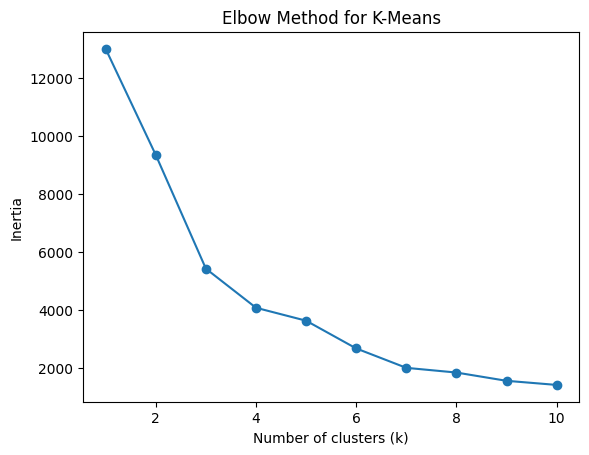

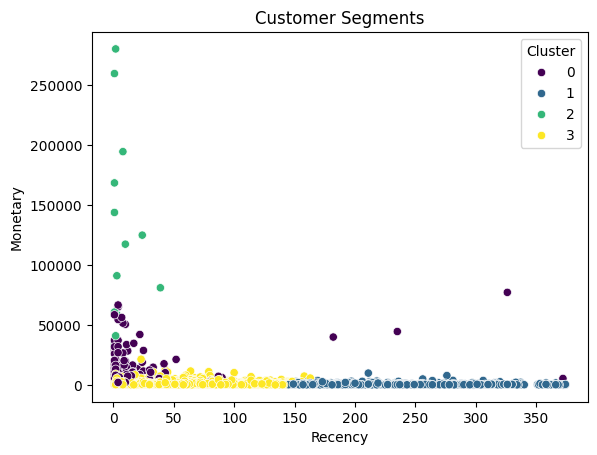

            Recency  Frequency       Monetary
Cluster                                      
0         15.672986  22.047393   12453.225924
1        248.564030   1.551789     478.107581
2          7.384615  82.692308  127338.313846
3         43.910580   3.655748    1349.698298


In [12]:
# Use Elbow method to find optimal k
inertia = []
for k in range(1, 11):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(rfm_scaled)
    inertia.append(model.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for K-Means')
plt.show()

# Choose k=4 (example) and train K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Visualize clusters
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rfm, palette='viridis')
plt.title("Customer Segments")
plt.show()

# Check cluster stats
print(rfm.groupby('Cluster').mean())


Market Basket Analysis (Apriori)" is about finding associations between products that customers often buy together, using the Apriori algorithm.

Data Transformation
Before running Apriori, we usually:
- Convert transaction data into a basket format (one row per transaction, columns for products, 1 if purchased, 0 if not).

### Apriori Algorithm
The algorithm - Finds frequent itemsets: groups of items bought together above a certain minimum support threshold.
Generates association rules with:
- Support – frequency of occurrence in transactions.
- Confidence – probability of buying item B when item A is bought.
- Lift – how much more likely B is bought with A compared to random chance.

In [13]:
from mlxtend.frequent_patterns import apriori, association_rules

# Create basket matrix (InvoiceNo x Product)
basket = (df
          .groupby(['InvoiceNo','Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

# Convert quantities to 0/1
basket = basket.applymap(lambda x: 1 if x > 0 else 0)


In [14]:
# Map InvoiceNo to CustomerID
invoice_customer_map = df[['InvoiceNo','CustomerID']].drop_duplicates()

# Merge cluster info
invoice_customer_map = invoice_customer_map.merge(rfm['Cluster'], left_on='CustomerID', right_index=True)

cluster_rules = {}

for cluster in rfm['Cluster'].unique():
    invoices = invoice_customer_map[invoice_customer_map['Cluster']==cluster]['InvoiceNo']
    cluster_basket = basket.loc[basket.index.isin(invoices)]
    
    # Frequent itemsets
    frequent_itemsets = apriori(cluster_basket, min_support=0.02, use_colnames=True)
    
    # Association rules
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
    
    cluster_rules[cluster] = rules.sort_values('lift', ascending=False).head(10)

# Example: show top rules for Cluster 0
print("Top rules for Cluster 0:")
print(cluster_rules[0])


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python31

Top rules for Cluster 0:
                                          antecedents  \
96                  (GREEN REGENCY TEACUP AND SAUCER)   
93  (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...   
95                   (PINK REGENCY TEACUP AND SAUCER)   
94  (GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...   
16               (GARDENERS KNEELING PAD CUP OF TEA )   
17                (GARDENERS KNEELING PAD KEEP CALM )   
19                  (GREEN REGENCY TEACUP AND SAUCER)   
18                   (PINK REGENCY TEACUP AND SAUCER)   
92  (PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...   
97                 (ROSES REGENCY TEACUP AND SAUCER )   

                                          consequents  antecedent support  \
96  (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...            0.040198   
93                  (GREEN REGENCY TEACUP AND SAUCER)            0.028160   
95  (GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...            0.034394   
94                   (PINK REGENCY TEAC

For unsupervised learning (K-Means clustering), we don’t have ground truth labels, so we can’t compute accuracy in the traditional sense. Instead, we use cluster quality metrics like:
- Silhouette Score – how well-separated and cohesive the clusters are.
- Calinski-Harabasz Index – higher means better-defined clusters.
- Davies-Bouldin Index – lower means better clusters.
- We can calculate these metrics and visualize the clusters to assess quality


In [16]:
# Silhouette Score (range -1 to 1, higher is better)
sil_score = silhouette_score(rfm_scaled, rfm['Cluster'])
print(f"Silhouette Score: {sil_score:.3f}")

# Calinski-Harabasz Index (higher is better)
ch_score = calinski_harabasz_score(rfm_scaled, rfm['Cluster'])
print(f"Calinski-Harabasz Index: {ch_score:.3f}")

# Davies-Bouldin Index (lower is better)
db_score = davies_bouldin_score(rfm_scaled, rfm['Cluster'])
print(f"Davies-Bouldin Index: {db_score:.3f}")


Silhouette Score: 0.616
Calinski-Harabasz Index: 3149.995
Davies-Bouldin Index: 0.752


- Silhouette Score: close to 1 → clusters are well-separated.
- Calinski-Harabasz Index: higher → better-defined clusters.
- Davies-Bouldin Index: lower → better clusters.

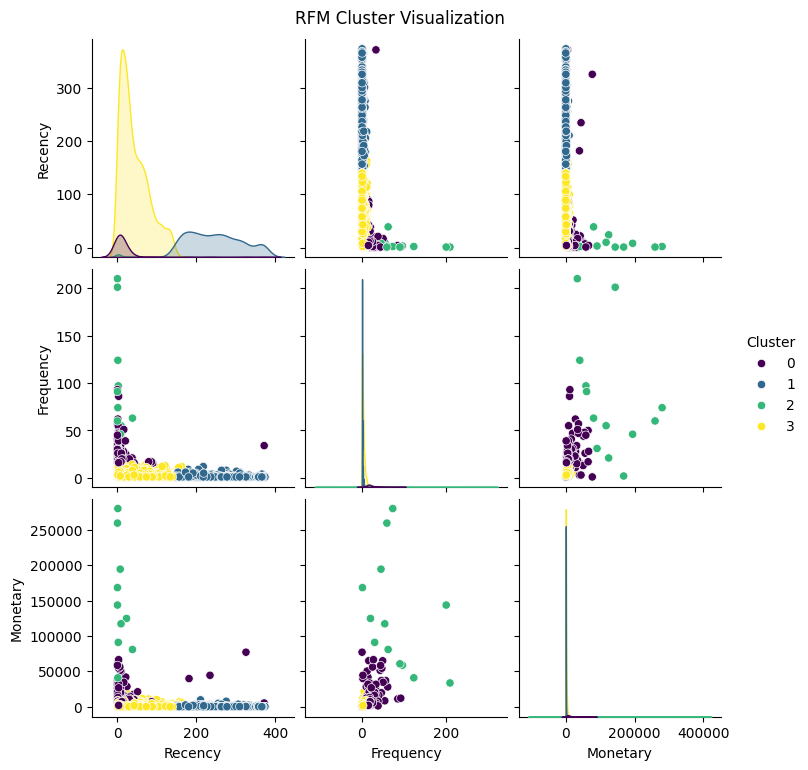

In [17]:
sns.pairplot(rfm, vars=['Recency','Frequency','Monetary'], hue='Cluster', palette='viridis')
plt.suptitle("RFM Cluster Visualization", y=1.02)
plt.show()